In [1]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = False # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

In [2]:
scene = load_scene("meshes/test_scene.xml")

In [3]:
if not no_preview:
    scene.preview();

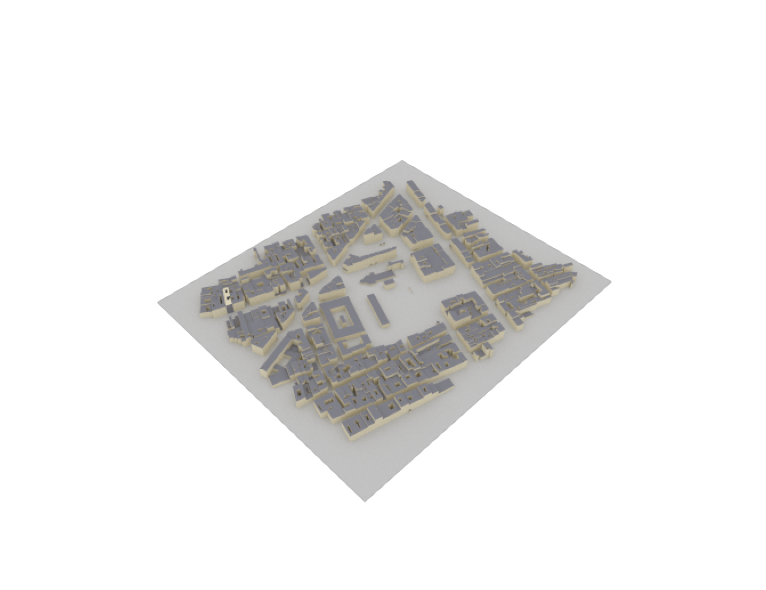

In [4]:
# Only availabe if a preview is open
if not no_preview:
    scene.render(camera="preview", num_samples=512);

In [5]:
# Only availabe if a preview is open
if not no_preview:
    scene.render_to_file(camera="preview",
                         filename="scene.png",
                         resolution=[650,500]);

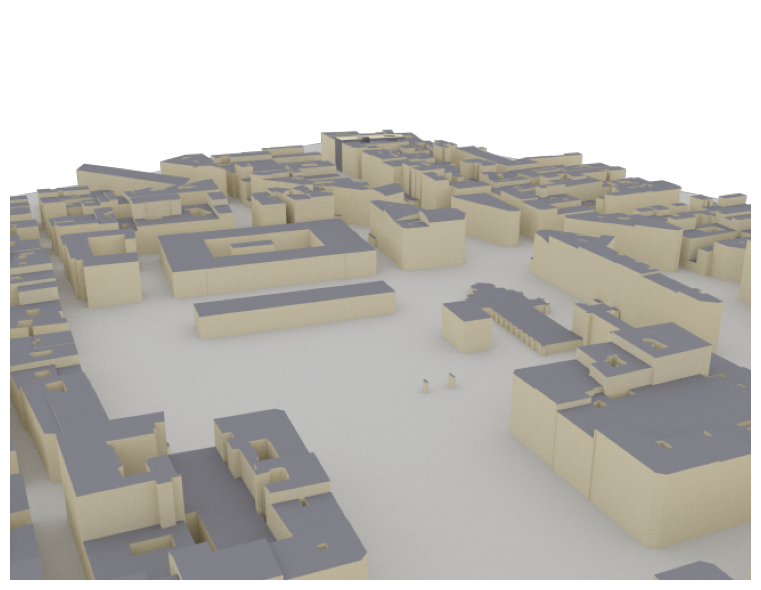

In [6]:
# Create new camera with different configuration
my_cam = Camera(position=[-250,250,150], look_at=[-15,30,28])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[650, 500], num_samples=512); # Increase num_samples to increase image quality

In [7]:
scene = load_scene("meshes/test_scene.xml", merge_shapes=False)
scene.objects

{'Plane': <sionna.rt.scene_object.SceneObject at 0x1179dbfe0>,
 'element-itu_marble': <sionna.rt.scene_object.SceneObject at 0x120490b00>,
 'element-itu_metal': <sionna.rt.scene_object.SceneObject at 0x120490ce0>,
 'element_001-itu_marble': <sionna.rt.scene_object.SceneObject at 0x120490dd0>,
 'element_001-itu_metal': <sionna.rt.scene_object.SceneObject at 0x120490ec0>,
 'element_002-itu_marble': <sionna.rt.scene_object.SceneObject at 0x120490fb0>,
 'element_002-itu_metal': <sionna.rt.scene_object.SceneObject at 0x120491070>,
 'element_003-itu_marble': <sionna.rt.scene_object.SceneObject at 0x120491160>,
 'element_003-itu_metal': <sionna.rt.scene_object.SceneObject at 0x120491250>,
 'element_004-itu_marble': <sionna.rt.scene_object.SceneObject at 0x120491340>,
 'element_004-itu_metal': <sionna.rt.scene_object.SceneObject at 0x120491430>,
 'element_005-itu_marble': <sionna.rt.scene_object.SceneObject at 0x1204914f0>,
 'element_005-itu_metal': <sionna.rt.scene_object.SceneObject at 0x120

In [8]:
floor = scene.get("Patchwork_Nazareth-itu_marble")

In [9]:
print("Position (x,y,z) [m]: ", floor.position)
print("Orientation (alpha, beta, gamma) [rad]: ", floor.orientation)
print("Scaling: ", floor.scaling)

Position (x,y,z) [m]:  [[-82.1317, 202.733, 11.1457]]
Orientation (alpha, beta, gamma) [rad]:  [[0, 0, 0]]
Scaling:  [[1, 1, 1]]


In [10]:
print("Velocity (x,y,z) [m/s]: ", floor.velocity)

Velocity (x,y,z) [m/s]:  [[0, 0, 0]]


In [11]:
floor.radio_material

ITURadioMaterial type=marble
                 eta_r=7.074
                 sigma=0.018
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

In [12]:
scene.frequency = 28e9 # in Hz; implicitly updates RadioMaterials that implement frequency dependent properties
floor.radio_material # Note that the conductivity (sigma) changes automatically

ITURadioMaterial type=marble
                 eta_r=7.074
                 sigma=0.120
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

In [13]:
scene = load_scene("meshes/test_scene.xml", merge_shapes=True) # Merge shapes to speed-up computations

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[118,-23,12],
                 display_radius=2)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

In [14]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

In [15]:
if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

In [16]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

Shape of a:  (1, 2, 1, 1, 11, 1)
Shape of tau:  (1, 2, 1, 1, 11)


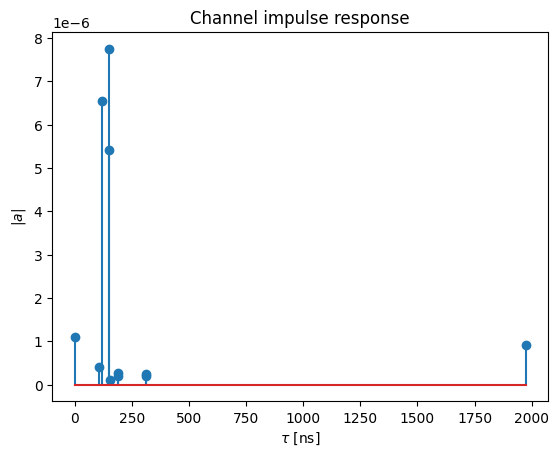

In [17]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

Shape of h_freq:  (1, 2, 1, 1, 1, 1024)


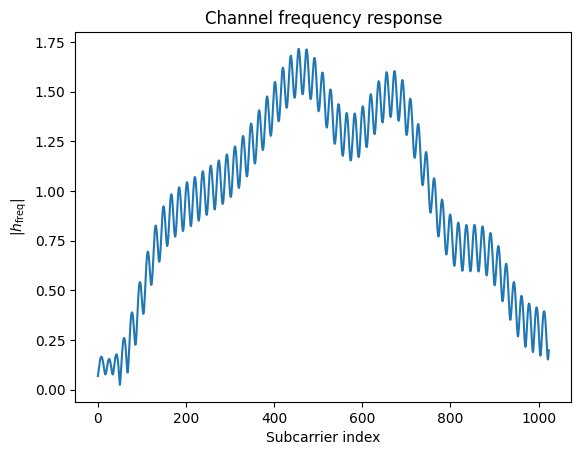

In [18]:
# OFDM system parameters
num_subcarriers = 1024
subcarrier_spacing=30e3

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

Shape of taps:  (1, 2, 1, 1, 1, 107)


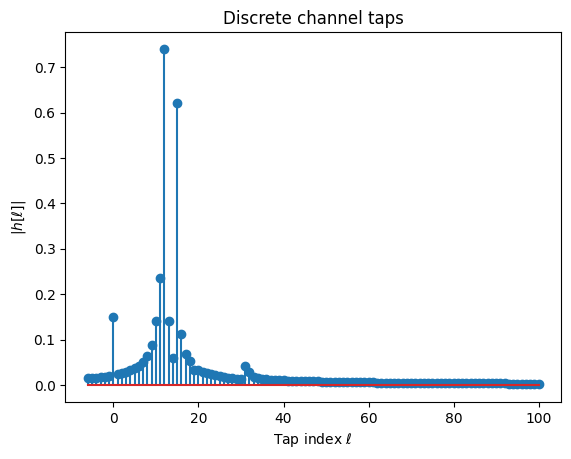

In [19]:
taps = paths.taps(bandwidth=100e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=-6,        # Smallest time lag
                  l_max=100,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 101), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

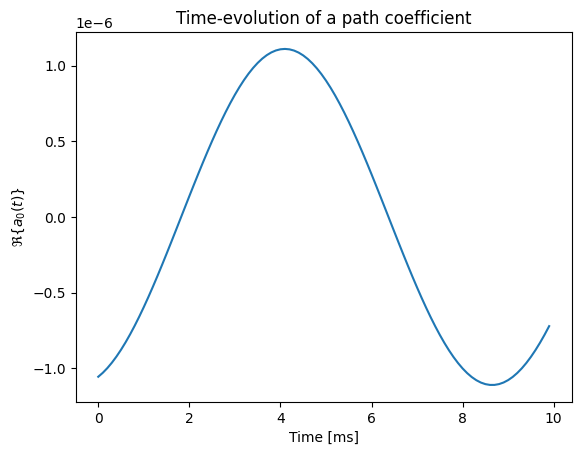

In [20]:
scene.get("tx").velocity = [10, 0, 0]

# Recompute propagation paths
paths_mob = p_solver(scene=scene,
                     max_depth=5,
                     los=True,
                     specular_reflection=True,
                     diffuse_reflection=False,
                     refraction=True,
                     synthetic_array=True,
                     seed=41)

# Compute CIR with time-evolution
num_time_steps=100
sampling_frequency = 1e4
a_mob, _ = paths_mob.cir(sampling_frequency=sampling_frequency,
                         num_time_steps=num_time_steps,
                         out_type="numpy")

# Inspect time-evolution of a single path coefficient
plt.figure()
plt.plot(np.arange(num_time_steps)/sampling_frequency*1000,
         a_mob[0,0,0,0,0].real);
plt.xlabel("Time [ms]");
plt.ylabel(r"$\Re\{a_0(t) \}$");
plt.title("Time-evolution of a path coefficient");

In [21]:
# rm_solver = RadioMapSolver()

# rm = rm_solver(scene=scene,
#                max_depth=5,
#                cell_size=[1,1],
#                samples_per_tx=10**6)

In [22]:
# if no_preview:
#     scene.render(camera=my_cam, radio_map=rm);
# else:
#     scene.preview(radio_map=rm);